# Libraries

In [11]:
import re
import ast
import torch
import tokenizers
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
# from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, T5Tokenizer, MT5ForConditionalGeneration, MT5Tokenizer, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns

# Reading Data

In [2]:
df_squad = pd.read_excel('data/Arabic squad/Arabic-SQuAD.xlsx')
print("arabic squad data loaded")
# df_arcd = pd.read_excel('ARCD/arcd-train.xlsx')
# print("arcd data loaded")
# df_tydiqa = pd.read_csv('tydiqa/tydiqa-arabic.csv')
# print("tydiqa data loaded")
# df_mlqa = pd.read_excel('MLQA/MLQA-dev-context-ar-question-ar.xlsx')
# print("mlqa data loaded")

arabic squad data loaded


# Data Overview

In [3]:
df_squad.head(10)

,id,question,context,answers,c_id
0,570bce516b8089140040fa42,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,570bce516b8089140040fa43,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,570bce516b8089140040fa44,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,570bce516b8089140040fa45,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,570bce516b8089140040fa46,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0
5,570bd0da6b8089140040fa60,لماذا تم ترميز الرمز بحيث تكون معظم الرموز معًا؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': 'لسهولة تحديد الهوية', 'answer_start...",1
6,570bd0da6b8089140040fa61,كم عدد المراكز في العمودين الأولين؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '32 موضع', 'answer_start': 128}]",1
7,570bd0da6b8089140040fa62,ما الذي قررت اللجنة أنه مهم؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,[{'text': 'دعم الأحرف الهجائية الكبيرة المكونة...,1
8,570bd0da6b8089140040fa63,أين كان الحرف ألف يضع في الموقف؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '41hex', 'answer_start': 757}]",1
9,570bd1adec8fbc190045bb22,تم دمج ASCII في ما مجموعة الأحرف الأخرى؟,تم دمج ASCII في مجموعة أحرف ونيكودي كأول 128 ر...,"[{'text': 'ونيكودي', 'answer_start': 28}]",2


In [4]:
df_squad.shape

(48344, 5)

In [5]:
df_squad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48344 entries, 0 to 48343
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48344 non-null  object
 1   question  48344 non-null  object
 2   context   48344 non-null  object
 3   answers   48344 non-null  object
 4   c_id      48344 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


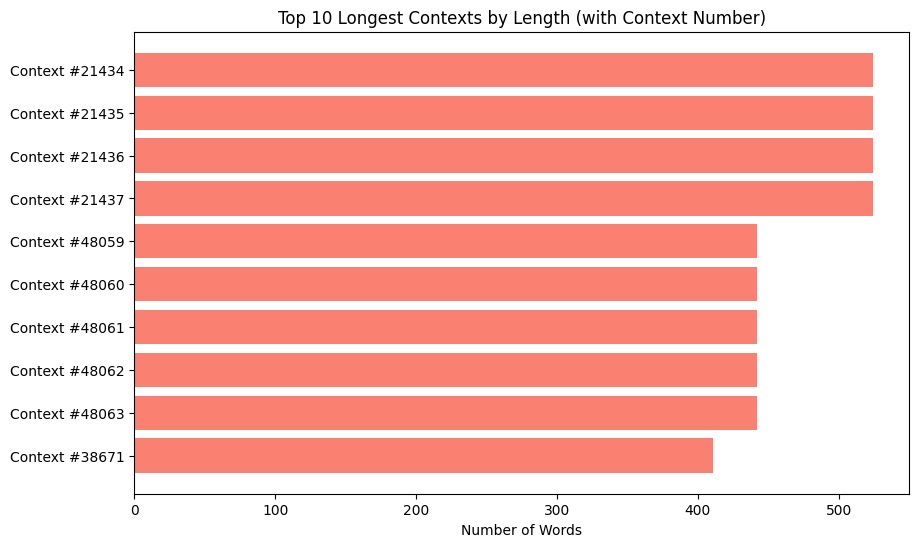

In [9]:
# Calculate context lengths (number of words)
df_squad['context_length'] = df_squad['context'].apply(lambda x: len(str(x).split()))

# Get the top 10 longest contexts and their indices
longest_contexts = df_squad.nlargest(10, 'context_length')[['context', 'context_length']]
longest_indices = longest_contexts.index.tolist()

# Plot bar graph for the top 10 longest contexts, showing their actual index (context number)
plt.figure(figsize=(10,6))
plt.barh(range(10), longest_contexts['context_length'], color='salmon')
plt.yticks(range(10), [f"Context #{idx}" for idx in longest_indices])
plt.xlabel('Number of Words')
plt.title('Top 10 Longest Contexts by Length (with Context Number)')
plt.gca().invert_yaxis()  # Highest at the top
plt.show()

# Removing id column

In [85]:
df_squad.drop('id', axis=1, inplace=True)

In [86]:
df_squad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48344 entries, 0 to 48343
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  48344 non-null  object
 1   context   48344 non-null  object
 2   answers   48344 non-null  object
 3   c_id      48344 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [87]:
df_squad.head(10)

,question,context,answers,c_id
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0
5,لماذا تم ترميز الرمز بحيث تكون معظم الرموز معًا؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': 'لسهولة تحديد الهوية', 'answer_start...",1
6,كم عدد المراكز في العمودين الأولين؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '32 موضع', 'answer_start': 128}]",1
7,ما الذي قررت اللجنة أنه مهم؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,[{'text': 'دعم الأحرف الهجائية الكبيرة المكونة...,1
8,أين كان الحرف ألف يضع في الموقف؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '41hex', 'answer_start': 757}]",1
9,تم دمج ASCII في ما مجموعة الأحرف الأخرى؟,تم دمج ASCII في مجموعة أحرف ونيكودي كأول 128 ر...,"[{'text': 'ونيكودي', 'answer_start': 28}]",2


# Text Preprocessing

## text cleaning functions

### Normalization

In [95]:
def remove_diacritics(text):
    # remove diacritics from the text as it may confuse the model
    return re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)


### Text cleaning

In [96]:
def remove_non_arabic(text):
    # Remove non-Arabic characters, keeping essential punctuation
    text = re.sub(r'[^\u0600-\u06FF\s؟]', '', text)
    return text

In [97]:
def remove_punk(text):
    # Remove punctuation
    arabic_punctuation = r'[،؛؟…!"#$%&\'()*+,-./:;<=>@^_`{|}~]'
    text = re.sub(arabic_punctuation, '', text)
    return text

In [98]:
def remove_extra_spaces(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [99]:
def remove_alef_variations(text):
    text = re.sub(r'[إأٱآ]', 'ا', text)
    return text

### Handling numbers

In [100]:
def handle_numbers(text, replace_with=None):
    if replace_with:
        text = re.sub(r'\d+', replace_with, text)
    else:
        text = re.sub(r'\d+', '', text)
    return text

## Stop word removal

In [101]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
stop_words = set(stopwords.words('arabic'))
print(stop_words)

{'كي', 'ماذا', 'خلف', 'أحد', 'ؤ', 'رابع', 'أيضا', 'بضع', 'عن', 'أجمع', 'شين', 'ثالث', 'إياكما', 'بعض', 'كأيّن', 'إلَيْكَ', 'غداة', 'هبّ', 'إلى', 'تلكم', 'ما', 'وإذ', 'ز', 'وَيْ', 'إنا', 'مكانكنّ', 'خامس', 'كأيّ', 'بسّ', 'أجل', 'ا', 'أمد', 'تسعمائة', 'بك', 'نوفمبر', 'جمعة', 'سبعة', 'فمن', 'كلَّا', 'عين', 'ميم', 'تلكما', 'هَذِه', 'أولاء', 'تانِ', 'سبت', 'آنفا', 'وإن', 'مازال', 'ذا', 'يناير', 'هاته', 'عشرة', 'س', 'سبعمائة', 'هَاتانِ', 'له', 'ترك', 'لعل', 'آ', 'ذه', 'لكيلا', 'مهما', 'منها', 'تلقاء', 'تِي', 'دونك', 'أفعل به', 'كأنّ', 'اثني', 'صباح', 'ت', 'أسكن', 'إما', 'ممن', 'حمٌ', 'ماي', 'إليكن', 'أربعمئة', 'كم', 'أفٍّ', 'ليسا', 'ذلكن', 'أم', 'ف', 'منذ', 'بات', 'آناء', 'لسنا', 'خمسين', 'من', 'بعدا', 'ارتدّ', 'حيثما', 'أنّى', 'هَذا', 'هذا', 'أل', 'أنبأ', 'ستة', 'أربعة', 'زعم', 'صاد', 'خ', 'فيفري', 'تي', 'ة', 'اللذان', 'درهم', 'مذ', 'نفس', 'هنا', 'هذه', 'هنالك', 'دولار', 'ذان', 'هلم', 'كليكما', 'بها', 'كلّما', 'أنتم', 'ظاء', 'هما', 'ثمَّ', 'ط', 'مساء', 'خمس', 'ثمانمئة', 'هاكَ', 'آه', 'قرش',

In [103]:
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

## Sentence splitting

In [104]:
def split_sentences(text):
    sentences = re.split(r'[؟.!؟]', text)
    # Remove empty sentences and strip spaces
    return [sentence.strip() for sentence in sentences if sentence.strip()]

## Remove additional spaces between letters

In [105]:
def fix_arabic_spacing(text):
    # Reconnect ا to the previous word if it is fully isolated
    text = re.sub(r'(\S)\s+ا\s+', r'\1ا ', text)

    # Reconnect أ and ي to the next word if they are fully isolated
    text = re.sub(r'\s+أ\s+(\S)', r' أ\1', text)
    text = re.sub(r'\s+ي\s+(\S)', r' ي\1', text)

    # Normalize spaces (remove extra spaces)
    text = remove_extra_spaces(text)

    return text

![image.png](attachment:image.png)

# Tokenization

In [108]:
!pip install SentencePiece 
import sentencepiece
print("SentencePiece version:", sentencepiece.__version__)

SentencePiece version: 0.2.0


### T5 tokenizer try

In [ ]:
# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("mt5-small")

In [ ]:
# Example Arabic text
text = "هذا نص تجريبي"

# Tokenize the text
encoded = tokenizer.tokenize(text)
# encoded = tokenizer.convert_tokens_to_string(encoded)
print("text after tokenize: ", encoded)

# Tokenize the text without padding
input_ids = tokenizer.encode(text, max_length=512, truncation=True, padding=False)
print("Token IDs (no padding):", input_ids)

# Decode token IDs back to text (skip special tokens)
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print("Decoded Text:", decoded_text)

In [ ]:
arabic_text = "هذا نص تجريبي"
tokens = tokenizer.tokenize(arabic_text)
print("Tokens:", tokens)

# Check if any tokens are unknown
unknown_tokens = [token for token in tokens if tokenizer.convert_tokens_to_ids(token) == 3]
print("Unknown Tokens:", unknown_tokens)

for token in tokens:
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"Token: {token}, Token ID: {token_id}")

vocab = tokenizer.get_vocab()
print("Vocabulary Size:", len(vocab))

# Check if some Arabic tokens exist in the vocabulary
arabic_tokens = ["ه", "ذا", "نص", "تجريبي"]
for token in arabic_tokens:
    if token in vocab:
        print(f"Token '{token}' found in vocabulary with ID: {vocab[token]}")
    else:
        print(f"Token '{token}' NOT found in vocabulary.")

after trying t5 tokenizer (small), it seems that this model has not trained enough on arabic words, it doesn't recognize it

### Compare between MT5 and AraBert

In [ ]:
from transformers import AutoTokenizer,MT5Tokenizer

# Initialize AraBERT tokenizer
arabert_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
t5_mutli_tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")


# Example Arabic text
arabic_text = "هذا نص تجريبي"

# Tokenize the text
araber_tokens = arabert_tokenizer.tokenize(arabic_text)
t5_tokens = t5_mutli_tokenizer.tokenize(arabic_text)
print("Arabic Bert Tokens:", araber_tokens)
print("T5 Tokens:", t5_tokens)

# Encode the text
arabert_input_ids = arabert_tokenizer.encode(arabic_text, max_length=512, truncation=True, padding=False)
t5_input_ids = t5_mutli_tokenizer.encode(arabic_text, max_length=512, truncation=True, padding=False)
print("Arabic Bert Token IDs:", arabert_input_ids)
print("T5 Token IDs:", t5_input_ids)

# Decode token IDs back to text
arabert_decoded_text = arabert_tokenizer.decode(arabert_input_ids, skip_special_tokens=True)
t5_decoded_text = t5_mutli_tokenizer.decode(t5_input_ids, skip_special_tokens=True)
print("Arabic Bert Decoded Text:", arabert_decoded_text)
print("T5 Decoded Text:", t5_decoded_text)

both models seems to be good at tokenizing the arabic, but arabic bert is better at tokenizing the words than T5 as it seems from the output

In [ ]:
def AraBert_tokenizer(text, max_length=512, padding="max_length", truncation=True):

    tokenized_output = tokenizer(
        text,
        max_length=max_length,
        padding=padding,
        truncation=truncation,
        return_tensors="pt"  # Return PyTorch tensors
    )
    return tokenized_output

### Selected tokenizer

In [114]:
# tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
# tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# tokenizer = T5Tokenizer.from_pretrained("UBC-NLP/araT5-base")
# tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

## Apply Functions on the text

In [115]:
df_squad.head(10)


,question,context,answers,c_id
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0
5,لماذا تم ترميز الرمز بحيث تكون معظم الرموز معًا؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': 'لسهولة تحديد الهوية', 'answer_start...",1
6,كم عدد المراكز في العمودين الأولين؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '32 موضع', 'answer_start': 128}]",1
7,ما الذي قررت اللجنة أنه مهم؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,[{'text': 'دعم الأحرف الهجائية الكبيرة المكونة...,1
8,أين كان الحرف ألف يضع في الموقف؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '41hex', 'answer_start': 757}]",1
9,تم دمج ASCII في ما مجموعة الأحرف الأخرى؟,تم دمج ASCII في مجموعة أحرف ونيكودي كأول 128 ر...,"[{'text': 'ونيكودي', 'answer_start': 28}]",2


In [116]:
df_squad['answers'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 48344 entries, 0 to 48343
Series name: answers
Non-Null Count  Dtype 
--------------  ----- 
48344 non-null  object
dtypes: object(1)
memory usage: 377.8+ KB


### Questions column

In [118]:
df_squad['processed_question'] = df_squad['question'].apply(remove_diacritics).apply(fix_arabic_spacing).apply(remove_extra_spaces).apply(remove_punk).apply(remove_alef_variations)

* i tried to apply text clean function but i think it made some question not understandable

In [119]:
df_squad['processed_question'].head(10)

0                              ما هو ASCII على اساس
1               كم شخصيات محددة موجودة في كود ASCII
2                    كم عدد احرف التحكم غير الطباعة
3                           كم شخصيات قابلة للطباعة
4               ما هو الفضاء المعروف ايضا باسم ماذا
5    لماذا تم ترميز الرمز بحيث تكون معظم الرموز معا
6                كم عدد المراكز في العمودين الاولين
7                       ما الذي قررت اللجنة انه مهم
8                   اين كان الحرف الف يضع في الموقف
9           تم دمج ASCII في ما مجموعة الاحرف الاخرى
Name: processed_question, dtype: object

In [120]:
## to check if there ? in every question or not
# list = []
# for i in range(len(df_squad['question'])):
#     c = df_squad['question'][i].count('؟')
#     list.append(c)
#     # print(df_squad['question'][0])
# list

### Context column

In [ ]:
# TODO: First see what preprocessing techniques we will use for the text for questions, contexts, answers(only text cleaning(i think))
# Done

# FIXME: Squad data is cleaned from the diacritics and been replaced with space, how to fix:
#           1- combine every ا to its previous word as the original word but some words may corrupt
#           2- combine every ى and أ with next word when coming in first
#           3- remove every alone character but this also maya corrupt some words as some words splitted from the diacritics (except for ب, ك and و)
# Fixed

In [122]:
# remove the extra spacing between letters problem
df_squad['processed_context'] = df_squad['context'].apply(fix_arabic_spacing)

In [123]:
# remove punctuation from words
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_punk)

In [124]:
# remove Alef variation from contexts
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_alef_variations)

In [125]:
# remove extra spaces between words
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_extra_spaces)

In [ ]:
df_squad['processed_context'][df_squad['c_id'] == 543].tolist()[0]

In [ ]:
unique_contexts_df = pd.DataFrame(df_squad['context'].unique().tolist(), columns=["unique context"])
unique_contexts_df.to_csv("unique_context.csv", index=False, header=True)

### Answers column

In [128]:
def extract_text(data):
    if isinstance(data, str):  # If data is a string, convert it to a list
        try:
            data = ast.literal_eval(data)  # Convert string to actual list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None

    if isinstance(data, list) and data:  # Check if it's a valid non-empty list
        first_item = data[0]  # Access the first dictionary
        if isinstance(first_item, dict):  # Ensure it's a dictionary
            return first_item.get('text', None)  # Get the 'text' value or None if not found
    return None

In [129]:
df_squad['processed_answers'] = df_squad['answers'].apply(extract_text)

In [130]:
df_squad['processed_answers'] = df_squad['processed_answers'].apply(remove_diacritics).apply(fix_arabic_spacing).apply(remove_extra_spaces).apply(remove_punk).apply(remove_alef_variations)

In [135]:
df_squad.head()

,question,context,answers,c_id,processed_question,processed_context,processed_answers
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0,ما هو ASCII على اساس,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,الابجدية الانجليزية
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0,كم شخصيات محددة موجودة في كود ASCII,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,128 حرفا محدد
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0,كم عدد احرف التحكم غير الطباعة,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,33 حرفا تحكما غير الطباعة
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0,كم شخصيات قابلة للطباعة,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,95 حرفا قابلا للطباعة
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0,ما هو الفضاء المعروف ايضا باسم ماذا,يعتمد ASCII اساسا على الابجدية الانجليزية ويقو...,رسما غير مرئي 223


# Save data

In [132]:
df_squad.to_excel("Arabic_squad_data_processed.xlsx", index=False, engine="openpyxl")  # Save as Excel

# Data Visualization

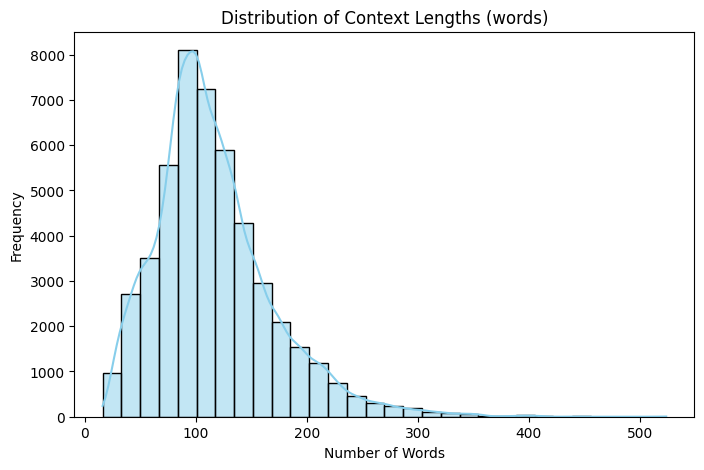

In [12]:
# Distribution of Context Lengths (words)
df_squad['context_length'] = df_squad['context'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(df_squad['context_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Context Lengths (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

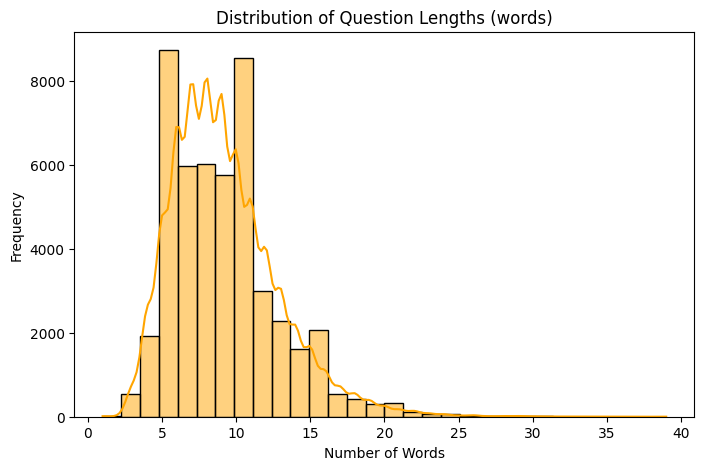

In [13]:
# Distribution of Question Lengths (words)
df_squad['question_length'] = df_squad['question'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(df_squad['question_length'], bins=30, kde=True, color='orange')
plt.title('Distribution of Question Lengths (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

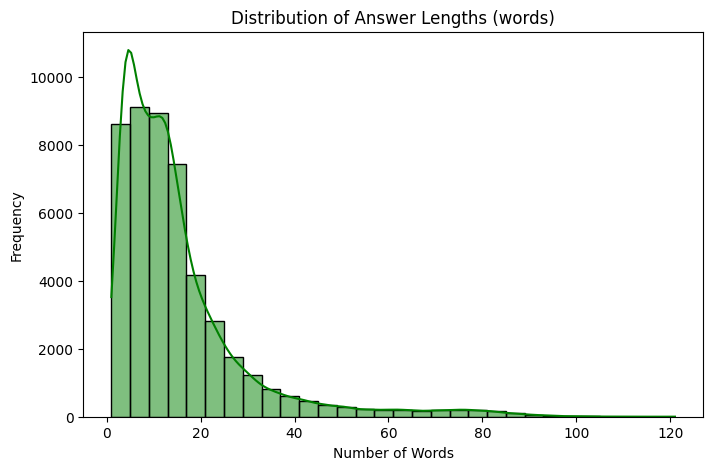

In [ ]:
# Distribution of Answer Lengths (words)
def get_answer_length(ans):
    if isinstance(ans, list) and ans:
        return len(str(ans[0].get('text', '')) if isinstance(ans[0], dict) else str(ans[0]).split())
    elif isinstance(ans, str):
        try:
            import ast
            ans_list = ast.literal_eval(ans)
            if isinstance(ans_list, list) and ans_list:
                return len(str(ans_list[0].get('text', '')) if isinstance(ans_list[0], dict) else str(ans_list[0]).split())
        except:
            return 0
    return 0

df_squad['answer_length'] = df_squad['answers'].apply(get_answer_length)
plt.figure(figsize=(8,5))
sns.histplot(df_squad['answer_length'], bins=30, kde=True, color='green')
plt.title('Distribution of Answer Lengths (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

C:\Users\Mohammed237\AppData\Local\Temp\ipykernel_25932\4250700274.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(reshaped_words), y=list(counts), palette='mako')


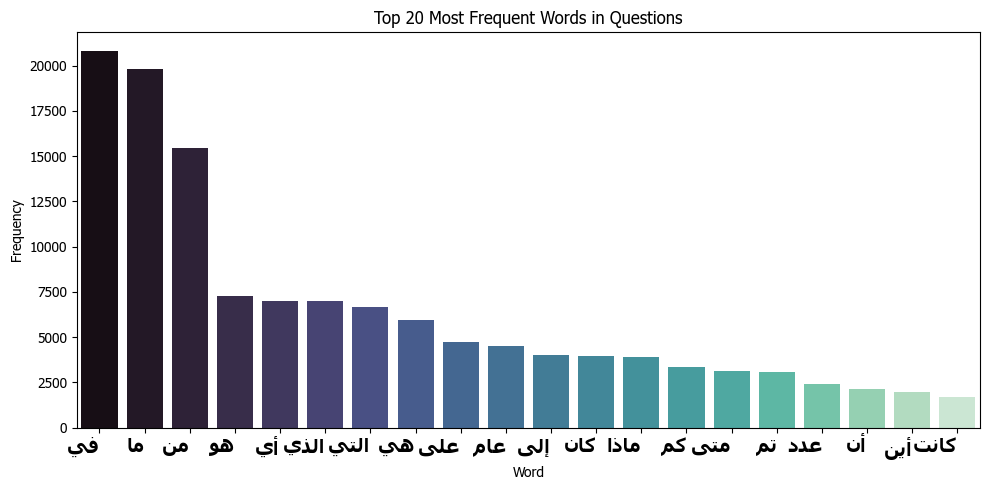

In [19]:
# Top 20 Most Frequent Words in Questions (after cleaning)
from collections import Counter
import re
import matplotlib
import arabic_reshaper
from bidi.algorithm import get_display

# Set font to support Arabic
matplotlib.rcParams['font.family'] = 'Tahoma'
matplotlib.rcParams['axes.unicode_minus'] = False

def clean_text(text):
    text = re.sub(r'[،؛؟…!"#$%&\'()*+,-./:;<=>@^_`{|}~]', '', str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

all_words = ' '.join(df_squad['question'].apply(clean_text)).split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

# Reshape and reorder Arabic words for correct display
reshaped_words = [get_display(arabic_reshaper.reshape(w)) for w in words]

plt.figure(figsize=(10,5))
sns.barplot(x=list(reshaped_words), y=list(counts), palette='mako')
plt.title('Top 20 Most Frequent Words in Questions')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=0, ha='right', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()